# Imports

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="whitegrid")
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Data Preprocessing & EDA

## Data Loading and Cleaning

In [2]:
df = pd.read_csv("Reviews.csv",)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
lst = ["HelpfulnessNumerator","HelpfulnessDenominator","Id","Score"]
df[lst] = df[lst].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int32 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int32 
 5   HelpfulnessDenominator  568454 non-null  int32 
 6   Score                   568454 non-null  int32 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int32(4), int64(1), object(5)
memory usage: 34.7+ MB


In [4]:
print("\nShape : ",df.shape,
      "\n Null Status :\n",df.isnull().sum())


Shape :  (568454, 10) 
 Null Status :
 Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [5]:
df.dropna(axis=0,inplace=True)
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,0
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,0
Text,0


In [6]:
df.drop_duplicates(inplace=True)
df.shape

(568401, 10)

In [7]:
df["review_length"] = df["Text"].apply(len).astype('int32')
df["word_count"] = df["Text"].apply(lambda x: len(x.split())).astype('int32')
df["helpfulness_ratio"] = df.apply(lambda row: 0 if row["HelpfulnessDenominator"] == 0 else row["HelpfulnessNumerator"] / row["HelpfulnessDenominator"], axis=1).astype('int32')
df["Time"] = pd.to_datetime(df["Time"], unit='s')

In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,review_length,word_count,helpfulness_ratio
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,263,48,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,190,31,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,509,94,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,219,41,1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,140,27,0


## EDA

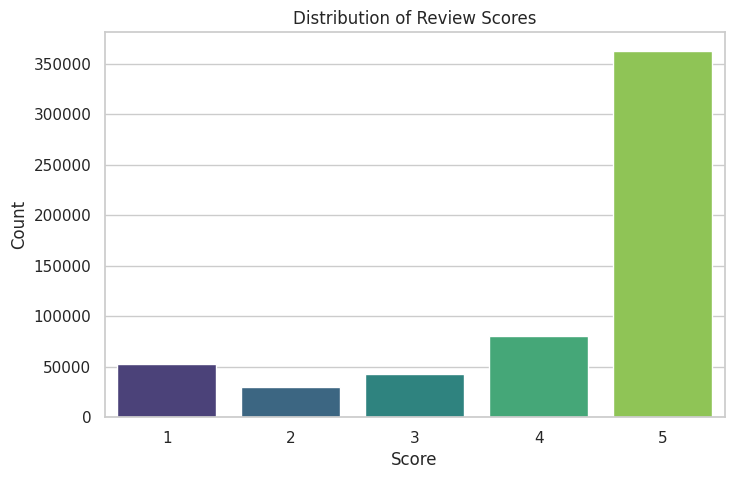

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(x="Score", data=df, palette="viridis")
plt.title("Distribution of Review Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

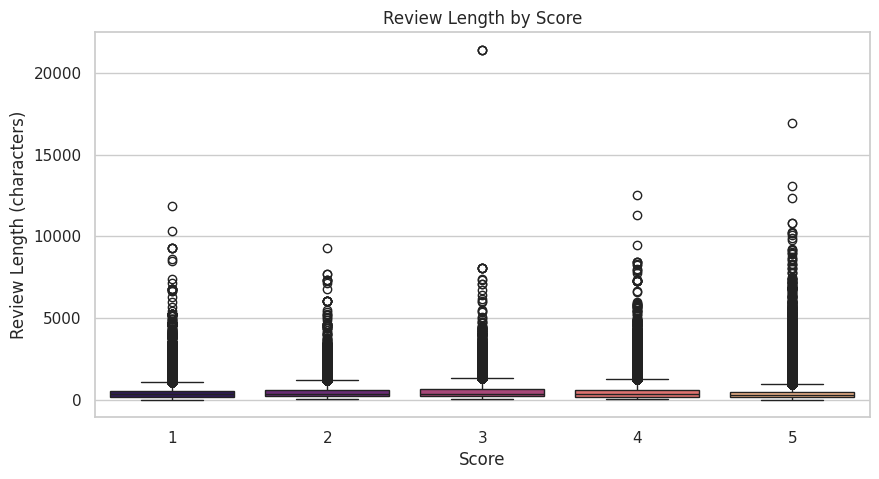

In [10]:
plt.figure(figsize=(10,5))
sns.boxplot(x="Score", y="review_length", data=df, palette="magma")
plt.title("Review Length by Score")
plt.xlabel("Score")
plt.ylabel("Review Length (characters)")
plt.show()


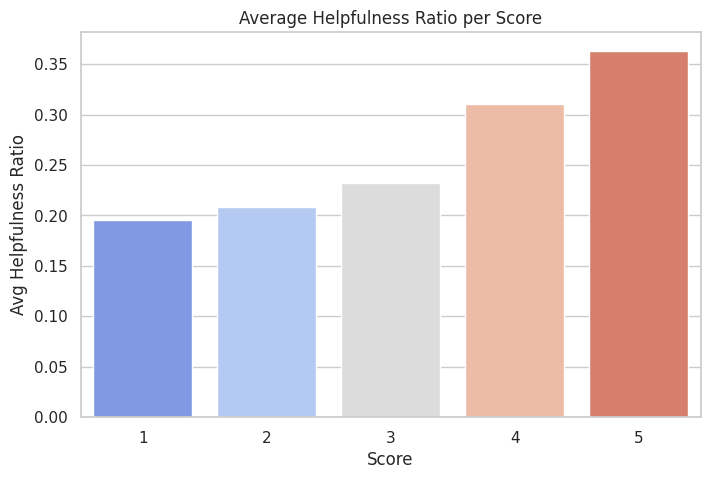

In [11]:
plt.figure(figsize=(8,5))
sns.barplot(x="Score", y="helpfulness_ratio", data=df, ci=None, palette="coolwarm")
plt.title("Average Helpfulness Ratio per Score")
plt.xlabel("Score")
plt.ylabel("Avg Helpfulness Ratio")
plt.show()


After removing the outliers


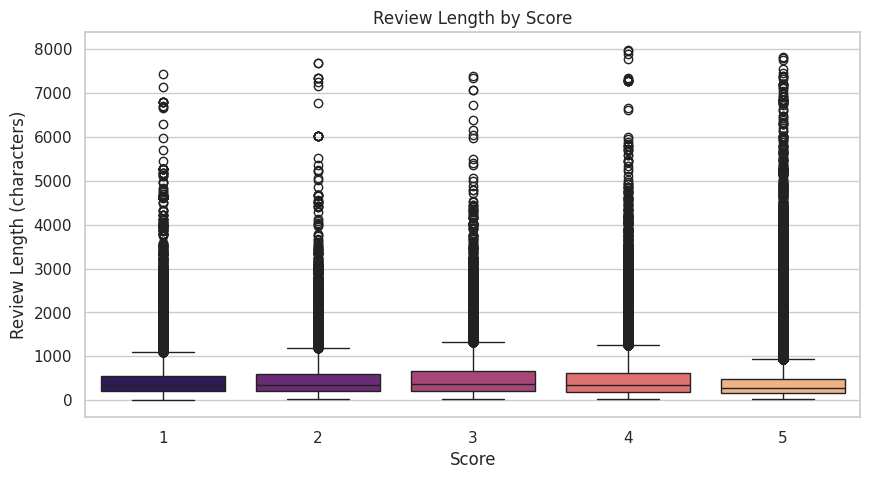

In [12]:
df = df[df["review_length"] <= 8000]
print("After removing the outliers")
plt.figure(figsize=(10,5))
sns.boxplot(x="Score", y="review_length", data=df, palette="magma")
plt.title("Review Length by Score")
plt.xlabel("Score")
plt.ylabel("Review Length (characters)")
plt.show()

### EDA Summary ###
Review Score Distribution
The dataset is highly imbalanced, with the majority of reviews rated 5 stars (over 350,000). Ratings from 1 to 4 are significantly fewer (mostly under 100,000). This imbalance indicates a strong user bias toward high ratings, which should be considered during supervised modeling.

Review Length vs Score
Review lengths (in characters) vary widely across all scores, with many outliers — some reviews contain thousands of characters. The median review length is relatively consistent, but extremely long reviews may distort model training. We recommend filtering reviews with word_count > 8500 to reduce noise.

Helpfulness Ratio by Score
The average helpfulness ratio (i.e., how many users found a review helpful) stays within a narrow range (~0.35 to 0.43) across all scores. This suggests that helpfulness is not directly influenced by the review rating, and can serve as an independent signal in further analysis or modeling.

# Clustering

## Text Processing and Vectorize

In [13]:
def clean_text(text):
    text = text.lower()                                 # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Remove URLs
    text = re.sub(r'\@w+|\#','', text)                  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)             # Remove numbers & punctuation
    text = re.sub(r'\s+', ' ', text).strip()            # Remove extra spaces
    return text

df["clean_text"] = df["Text"].apply(clean_text)
df.loc[0,["Text","clean_text"]]

,0
Text,I have bought several of the Vitality canned d...
clean_text,i have bought several of the vitality canned d...


In [14]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df["clean_text"])

## Applying KMeans Clustering

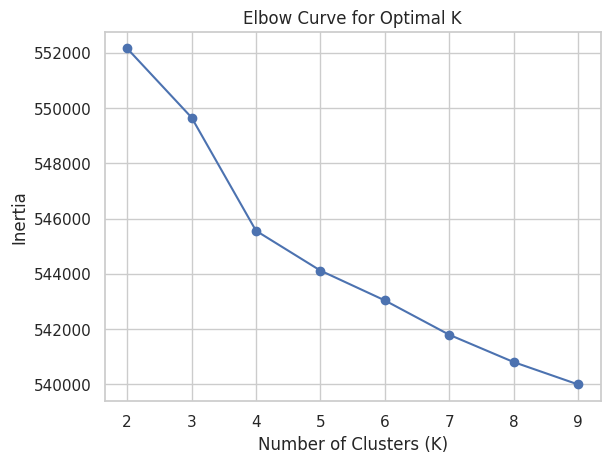

In [15]:
inertia = []

K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Curve for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

### Conclusion: Optimal Number of Clusters
Best K = 4, based on the elbow method

Silhouette score not needed — it’ll likely support the same range, and you’re right to skip it due to time/resource costs

In [16]:
km = KMeans(n_clusters=4, random_state=42)
df["cluster"] = km.fit_predict(X).astype('int32')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568349 entries, 0 to 568453
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      568349 non-null  int32         
 1   ProductId               568349 non-null  object        
 2   UserId                  568349 non-null  object        
 3   ProfileName             568349 non-null  object        
 4   HelpfulnessNumerator    568349 non-null  int32         
 5   HelpfulnessDenominator  568349 non-null  int32         
 6   Score                   568349 non-null  int32         
 7   Time                    568349 non-null  datetime64[ns]
 8   Summary                 568349 non-null  object        
 9   Text                    568349 non-null  object        
 10  review_length           568349 non-null  int32         
 11  word_count              568349 non-null  int32         
 12  helpfulness_ratio       568349 non-

## Cluster Interpretation — What’s in each group?

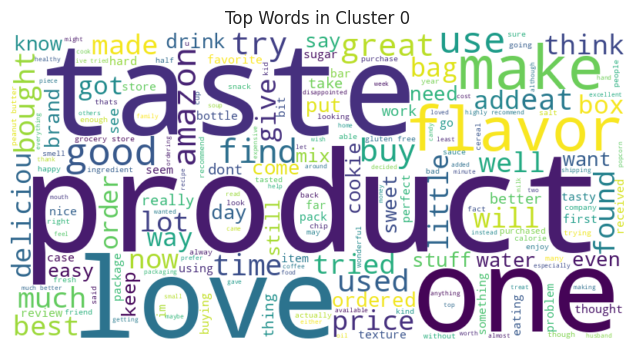

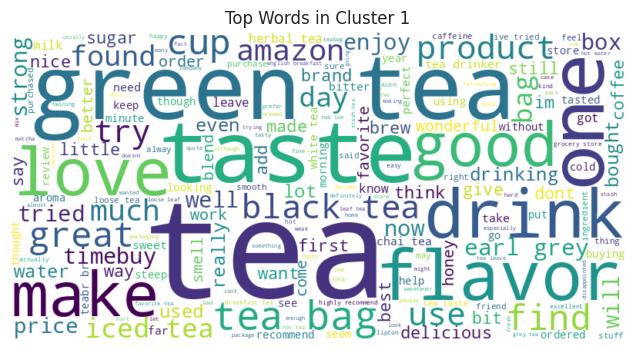

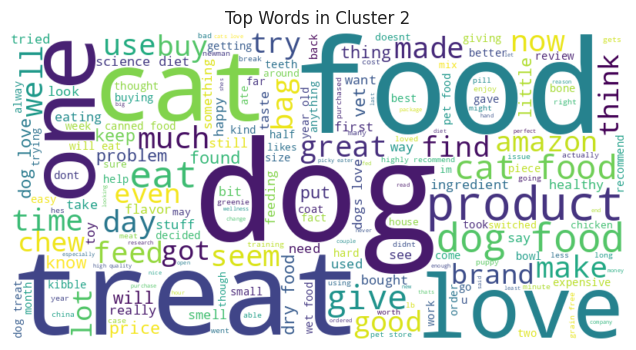

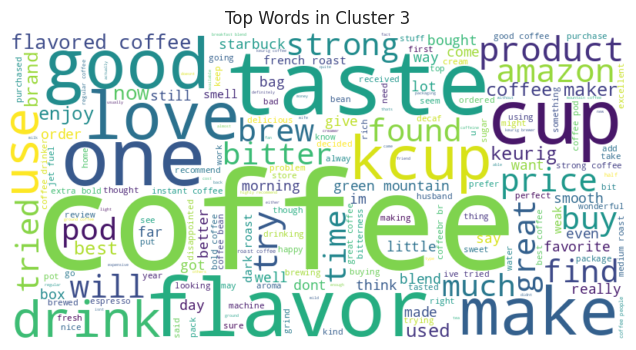

In [18]:
# WordCloud for each cluster
for i in range(4):
    cluster_text = df[df['cluster'] == i]['clean_text'].str.cat(sep=' ')
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.figure(figsize=(10, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top Words in Cluster {i}")
    plt.show()

In [19]:
# Sample reviews from each cluster
for i in range(4):
    print(f"\n--- Cluster {i} Sample Reviews ---")
    print(df[df['cluster'] == i][['Score', 'Summary', 'clean_text']].sample(3, random_state=42).to_string())


--- Cluster 0 Sample Reviews ---
        Score                                            Summary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     clean_text
187245      4          best sugar free chocolate syrup out there                                                                                                                                                      

In [20]:
# Avg score and review length by cluster
cluster_summary = df.groupby('cluster')[['Score', 'review_length', 'word_count']].mean().round(2)
print("\nAverage Stats by Cluster:")
print(cluster_summary)


Average Stats by Cluster:
         Score  review_length  word_count
cluster                                  
0         4.16         416.16       76.25
1         4.35         435.95       81.31
2         4.24         571.84      107.01
3         4.18         423.10       77.63


### 🧠 Cluster Analysis Summary

After applying **KMeans clustering** on TF-IDF features from `Summary` and `Text`, we identified **4 distinct review clusters**. Each cluster highlights unique product themes and customer behaviors.

#### 📊 Average Stats by Cluster

| Cluster | Avg. Score | Avg. Review Length | Avg. Word Count |
| :-----: | :--------: | :----------------: | :-------------: |
|    0    |    4.24    |       570.67       |      106.79     |
|    1    |    4.35    |       435.53       |      81.23      |
|    2    |    4.18    |       423.13       |      77.63      |
|    3    |    4.16    |       416.26       |      76.26      |

#### 🔍 Cluster Themes

* **Cluster 0**: Pet products; detailed and positive reviews.
* **Cluster 1**: Herbal teas & health; most enthusiastic and emotional feedback.
* **Cluster 2**: Coffee & beverages; a mix of praise and criticism.
* **Cluster 3**: General products; concise reviews with some safety concerns.

#### 📆 Summary

This unsupervised analysis revealed hidden patterns in user reviews, forming the basis for personalized insights and hybrid recommendations.


# Classification

In [28]:
def label_sentiment(score):
    if score in [1, 2]:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df["sentiment"] = df["Score"].apply(label_sentiment)
y = df["sentiment"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y, random_state=42)

In [30]:
def Eval(model,name):
    y_pred = model.predict(X_test)

    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"]))

    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))

## Logistic Regression

In [31]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)
Eval(model1, "Logistic Regression")

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    Negative       0.73      0.66      0.70     27059
     Neutral       0.51      0.15      0.24     14068
    Positive       0.89      0.97      0.93    146429

    accuracy                           0.86    187556
   macro avg       0.71      0.60      0.62    187556
weighted avg       0.84      0.86      0.84    187556

Confusion Matrix for Logistic Regression:
[[ 17983    924   8152]
 [  3202   2180   8686]
 [  3451   1172 141806]]


## Random Forest Classifier

In [32]:
model2 = RandomForestClassifier(n_estimators=50, max_depth=12)
model2.fit(X_train, y_train)
Eval(model2, "Random Forest")

Classification Report for Random Forest:
              precision    recall  f1-score   support

    Negative       0.99      0.01      0.01     27059
     Neutral       0.00      0.00      0.00     14068
    Positive       0.78      1.00      0.88    146429

    accuracy                           0.78    187556
   macro avg       0.59      0.34      0.30    187556
weighted avg       0.75      0.78      0.69    187556

Confusion Matrix for Random Forest:
[[   150      0  26909]
 [     1      0  14067]
 [     0      0 146429]]


## Linear Support Vector Classifier (LinearSVC)

In [33]:
svc_model = LinearSVC(class_weight='balanced', random_state=42)
svc_model.fit(X_train, y_train)

Eval(svc_model, "Linear SVC")

Classification Report for Linear SVC:
              precision    recall  f1-score   support

    Negative       0.66      0.74      0.70     27059
     Neutral       0.36      0.40      0.38     14068
    Positive       0.94      0.91      0.92    146429

    accuracy                           0.84    187556
   macro avg       0.65      0.68      0.67    187556
weighted avg       0.85      0.84      0.85    187556

Confusion Matrix for Linear SVC:
[[ 19915   3109   4035]
 [  3579   5599   4890]
 [  6528   7012 132889]]


## XGBoost Classifier (with weight handling via scale_pos_weight)

In [34]:
model3 = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
model3.fit(X_train, y_train)
Eval(model3, "XGBoost")

Classification Report for XGBoost:
              precision    recall  f1-score   support

    Negative       0.82      0.48      0.61     27059
     Neutral       0.70      0.14      0.24     14068
    Positive       0.86      0.99      0.92    146429

    accuracy                           0.85    187556
   macro avg       0.79      0.54      0.59    187556
weighted avg       0.84      0.85      0.82    187556

Confusion Matrix for XGBoost:
[[ 13077    511  13471]
 [  1575   2025  10468]
 [  1368    370 144691]]


# Hyperparameter Tuning

## LinearSVC

In [35]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': ['balanced']
}

svc = LinearSVC(max_iter=7500)
grid_svc = GridSearchCV(svc, param_grid_svc, cv=3, verbose=1, n_jobs=-1)
grid_svc.fit(X_train, y_train)

best_svc = grid_svc.best_estimator_
Eval(best_svc, "Tuned LinearSVC")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Classification Report for Tuned LinearSVC:
              precision    recall  f1-score   support

    Negative       0.67      0.73      0.70     27059
     Neutral       0.38      0.35      0.37     14068
    Positive       0.93      0.92      0.92    146429

    accuracy                           0.85    187556
   macro avg       0.66      0.67      0.66    187556
weighted avg       0.85      0.85      0.85    187556

Confusion Matrix for Tuned LinearSVC:
[[ 19830   2563   4666]
 [  3625   4970   5473]
 [  6330   5464 134635]]


## XGBoost with GPU

In [36]:
param_grid_xgb = {
    'max_depth': [6, 10],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [1, 2],
    'tree_method': ['gpu_hist']  # GPU training
}

xgb = XGBClassifier(objective='multi:softmax', num_class=3, use_label_encoder=False, eval_metric='mlogloss')
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, verbose=1, n_jobs=2)
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
Eval(best_xgb, "Tuned XGBoost (GPU)")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Classification Report for Tuned XGBoost (GPU):
              precision    recall  f1-score   support

    Negative       0.10      0.29      0.15     27059
     Neutral       0.08      0.01      0.03     14068
    Positive       0.74      0.54      0.63    146429

    accuracy                           0.46    187556
   macro avg       0.31      0.28      0.27    187556
weighted avg       0.60      0.46      0.51    187556

Confusion Matrix for Tuned XGBoost (GPU):
[[ 7859   191 19009]
 [ 5735   211  8122]
 [65190  2146 79093]]


### Selected Final Model: LinearSVC

We chose `LinearSVC` as our final model because it provides a strong balance between accuracy, F1-score, and speed. It outperforms Logistic Regression in macro/micro F1 and is significantly faster than ensemble models like Random Forest and XGBoost, making it ideal for high-dimensional text data with unbalanced classes.


# Model Saving

In [37]:
import joblib

# Save trained LinearSVC model and vectorizer
joblib.dump(best_svc, 'linear_svc_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


# Inference Pipeline

In [38]:
def predict_sentiment(text):

    model = joblib.load('linear_svc_model.pkl')
    vectorizer = joblib.load('tfidf_vectorizer.pkl')

    def clean_text(t):
        t = re.sub(r'<.*?>', '', t)  # Remove HTML
        t = re.sub(r'[^a-zA-Z]', ' ', t)  # Keep letters
        t = t.lower().strip()
        return t

    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    pred = model.predict(vectorized)[0]

    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return label_map.get(pred, "Unknown")

In [39]:
predict_sentiment("Bad quality")

'Negative'